In [8]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from matplotlib import pyplot as plt
import random
from scipy.stats import ttest_ind
from matplotlib import rcParams

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.cell_roi import RandomROISample
from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, ROICreator
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
####################################################################################

In [9]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-init/"
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices.csv'
csv_columns = ['Date',
             'Slice/Loc/Rec',
             'Stim Location',
             'L4 barrel 1 Latency',
             'L4 barrel 2 Latency',
             'L4 barrel 3 Latency',
             'L4 barrel 1 SNR',
             'L4 barrel 2 SNR',
             'L4 barrel 3 SNR',
             'ROI jpg',
              'Age',
              'Infusion',
              'Sex',
              'Stim (uA)',
              'Delta latency 1 (barrel 1 - barrel 2)',
              'Delta latency 2 (barrel 3 - barrel 2)']

enable_photoZ_interaction = True
initialize_photoZ = True
snr_cutoff_signal = 0
amp_cutoff_signal = 0

# Load reference data for all slices
reference_file = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/" + cell_type_prefix +"_catalog.csv"
reference_df = pd.read_csv(reference_file)
ref_cols = ['Age', 
          'Sex', 
          "Infusion", 
          'Stim (uA)']

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,L4 barrel 2 SNR,L4 barrel 3 SNR,ROI jpg,Age,Infusion,Sex,Stim (uA),Delta latency 1 (barrel 1 - barrel 2),Delta latency 2 (barrel 3 - barrel 2),abs(delta 1),abs(delta 2)
0,2/28/2023,02_01_01,L5,50.3009,50.8406,49.3457,2.940390,10.630900,6.484390,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,NaN,-1.4949,NaN,1.4949
1,2/28/2023,02_01_03,L5,50.6451,50.8291,49.8348,4.437170,9.880730,5.899120,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,NaN,-0.9943,NaN,0.9943
2,2/28/2023,02_02_02,L5,49.9882,51.3212,51.1805,2.045210,5.142090,2.921330,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,NaN,NaN,NaN,NaN
3,2/28/2023,03_01_01,L2/3,52.5719,51.2136,52.9013,9.405090,10.237200,5.780930,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.3583,1.6877,1.3583,1.6877
4,2/28/2023,03_02_01,L2/3,51.6168,50.1283,50.9250,25.204500,27.827700,26.272100,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.4885,0.7967,1.4885,0.7967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,6/28/2023,02_04_03,L4,58.3278,94.0000,94.0000,1.284740,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
120,6/28/2023,03_01_10,L4,94.0000,51.1749,51.3676,0.000000,0.263371,1.110580,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
121,6/28/2023,03_02_03,L4,58.9868,58.3472,94.0000,0.077615,0.514122,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN
122,6/28/2023,03_03_01,L4,50.7398,94.0000,94.0000,0.862532,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,NaN,NaN,NaN,NaN


In [10]:
# set up PhotoZ (open it manually)
'''if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ()'''

'if enable_photoZ_interaction:\n    aPhz = AutoPhotoZ(data_dir=data_dir)\n    if initialize_photoZ:\n        aPhz.prepare_photoZ()'

In [20]:
# create random ROI samples of 1 pixel
# Generate ROI files of specified sizes
roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if 'ROIs-barrels' in file:

            # load SNR map
            def load_map(fn2):
                data_arr = pd.read_csv(fn2,
                                    sep='\t',
                                    header=None,
                                    names=['Index',  'Values'])
                data_arr = np.array(data_arr['Values']).reshape((80, 80))
                return data_arr

            data = {
                'snr_map': load_map(subdir + '/snr_map.dat'),
                'amp_map': load_map(subdir + '/amp_map.dat')
            }
            print(data['snr_map'].shape)

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True)
                        for roi in barrel_rois]
            
            # compute stim point
            stim_point = barrel_rois[0].get_center()

            barrel_rois = [roi.get_points() for roi in barrel_rois]
            
            # map pixel to ROI number
            barrel_roi_map = {}
            for i in range(len(barrel_rois)):
                for px in barrel_rois[i]:
                    px_string = str(px[0]) + ',' + str(px[1])
                    barrel_roi_map[px_string] = i

            # take sample of 100 random pixels from barrel ROIs
            new_rois = {i: [] for i in range(len(barrel_rois))}
            nr_map = {}
            while(any([len(new_rois[k]) < 100 for k in new_rois])):
                i, j = roi_sampler.get_random_point()
                px_string = str(j) + ',' + str(i)
                if px_string not in barrel_roi_map \
                    or (j,i) in nr_map \
                    or data['snr_map'][i][j] < snr_cutoff_signal \
                    or data['amp_map'][i][j] < amp_cutoff_signal:
                    continue
                else:
                    barrel_idx = barrel_roi_map[px_string]
                    if len(new_rois[barrel_idx]) < 100:
                        new_rois[barrel_idx].append([j, i])
                    nr_map[(j, i)] = 1
                occupancy = [len(new_rois[k]) for k in new_rois]
            print(len(new_rois))

            # compute distance from stim point for each sampled point
            distances = {}
            for k in new_rois:
                distances[k] = []
                for px in new_rois[k]:
                    distances[k].append(math.sqrt(
                        (px[0] - stim_point[0])**2 + (px[1] - stim_point[1])**2
                    ))

            # convert pixels to diode numbers
            roi_cr = ROICreator(None)
            for k in new_rois:
                new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            for barrel_idx in new_rois:
                rfw.write_regions_to_dat(subdir + '/ROIs-rand_' 
                                        + str(barrel_idx) + '.dat',
                            new_rois[barrel_idx])
            
            # save file names to map
            data_file_map[subdir] = [
                subdir + '/ROIs-rand_' + str(barrel_idx) + '.dat'
                for barrel_idx in new_rois
            ]
            distance_map[subdir] = distances

(80, 80)
3
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-init/select\06-26-23/ROIs-rand_0.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-init/select\06-26-23/ROIs-rand_1.dat
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-init/select\06-26-23/ROIs-rand_2.dat


0_latency.dat 0
1_latency.dat 1
2_latency.dat 2
[0, 1]
p_val for pair [0, 1] : 2.177351996537119e-137 t_stat: -67.08014490323666
[1, 2]
p_val for pair [1, 2] : 1.1434035275835778e-30 t_stat: -14.393036863646582
0
1
2


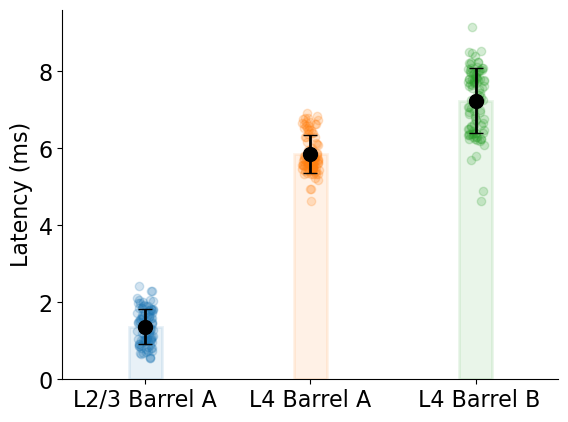

In [33]:
# latency files for each barrel sample was saved from PhotoZ manually. Load them
colors = ['tab:blue', 'tab:orange', 'tab:green']
rcParams.update({'font.size': 16})

markers = ['o', 'o']
i = 0
for subdir, dirs, files in os.walk(data_dir):
    barrel_data = {}
    for file in files:
        if file.endswith('.dat') and 'latency' in file:
            # load latency data
            latency_data = pd.read_csv(subdir + '/' + file,
                                    sep='\t',
                                    header=None,
                                    names=['Barrel', 'Latency'])
            latency_data = latency_data.set_index('Barrel')
            latency_data['Latency'] -= 48.8
            # latency_data = latency_data[latency_data['Latency'] > 48.8]
            
            # extract barrel number from filename
            barrel_num = int(file.split('_latency')[0][-1])
            print(file, barrel_num)

            barrel_data[barrel_num] = latency_data

    # determine sginificance of latency differences
    if len(barrel_data.keys()) < 1:
        continue
    for pair in [[0, 1], [1, 2]]:
        print(pair)
        dist1 = barrel_data[pair[0]]['Latency']
        dist2 = barrel_data[pair[1]]['Latency']

            
        # one-sided t-test if sample means are different
        t_stat, p_val = ttest_ind(dist1, dist2, equal_var=False)
        print("p_val for pair", pair, ":", p_val, "t_stat:", t_stat)

    # plot the latency data
    for k in barrel_data:
        print(k)
        barrel_idx = [k + random.uniform(-0.05, 0.05) for _ in range(len(barrel_data[k]['Latency']))]
        plt.scatter(barrel_idx, barrel_data[k]['Latency'], alpha=0.2, color=colors[k], marker=markers[i])

        # add a transparent barplot of the mean latency for each barrel
        plt.bar(k, barrel_data[k]['Latency'].mean(), alpha=0.1, color=colors[k], width=0.2,
                edgecolor=colors[k], linewidth=2, label='Barrel ' + str(k))
        plt.errorbar(k, barrel_data[k]['Latency'].mean(), yerr=barrel_data[k]['Latency'].std(), 
                    fmt='o', color='black', markersize=10, capsize=5, elinewidth=2)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        # significance_levels = [get_sig_level(x) for x in pvals]
        # print(significance_levels)
    plt.xticks([0, 1, 2], ['L2/3 Barrel A', 'L4 Barrel A', ' L4 Barrel B'])
    plt.ylabel('Latency (ms)')
    plt.xlim(-0.5, 2.5)
    i += 1

# remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('P:/John/crossing-paper/input/latency_dist_crossing.png')
plt.show()


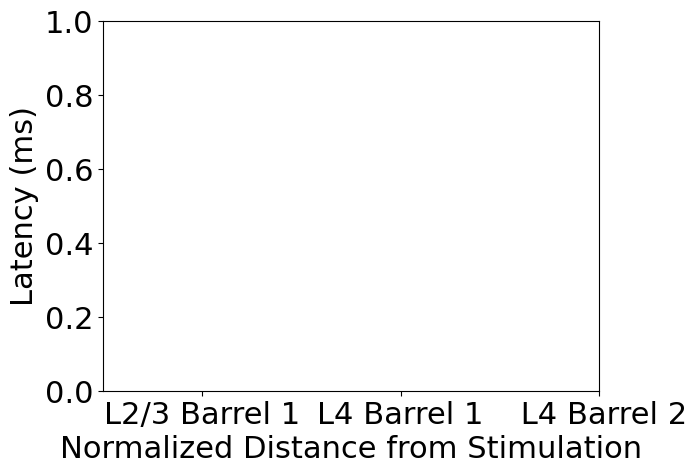

In [13]:
# latency files for each barrel sample was saved from PhotoZ manually. Load them
colors = ['tab:blue', 'tab:orange', 'tab:green']
i = 0
for subdir, dirs, files in os.walk(data_dir):
    barrel_data = {}
    for file in files:
        if file.endswith('.dat') and 'latency' in file:
            # load latency data
            latency_data = pd.read_csv(subdir + '/' + file,
                                    sep='\t',
                                    header=None,
                                    names=['Barrel', 'Latency'])
            latency_data = latency_data.set_index('Barrel')
            # latency_data = latency_data[latency_data['Latency'] > 48.8]
            
            # extract barrel number from filename
            barrel_num = int(file.split('_latency')[0][-1])
            print(file, barrel_num)

            barrel_data[barrel_num] = latency_data

    # plot the latency data
    for k in barrel_data:
        print(len(distance_map[subdir][k]), len(barrel_data[k]['Latency']))
        c =colors[i % 3]

        # normalize distances to 0-1
        max_dist = max(distance_map[subdir][k])
        distance_map[subdir][k] = [x / max_dist for x in distance_map[subdir][k]]
        dist = [k + x for x in distance_map[subdir][k]]
        plt.scatter(dist, barrel_data[k]['Latency'], alpha=0.2, color=c)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        # significance_levels = [get_sig_level(x) for x in pvals]
        # print(significance_levels)
    plt.xticks([0.5, 1.5, 2.5], ['L2/3 Barrel 1', 'L4 Barrel 1', ' L4 Barrel 2'])
    plt.ylabel('Latency (ms)')
    plt.xlabel('Normalized Distance from Stimulation')
    i += 1
plt.show()


In [14]:
print(barrel_data.keys())

dict_keys([])


In [15]:
# compute statistics on barrel pairs:
#    1) whether delta latency should be considered based on SNR
#    2) Delta latency between L4 barrels (b1 - b2, b3 - b2)
df['Delta latency 1 (barrel 1 - barrel 2)'] = df['L4 barrel 1 Latency'] - df['L4 barrel 2 Latency']
df['Delta latency 2 (barrel 3 - barrel 2)'] = df['L4 barrel 3 Latency'] - df['L4 barrel 2 Latency']

# if either barrel 1 or barrel 2 has low SNR, don't compute the delta latency between these two
df.loc[(df['L4 barrel 1 SNR'] < snr_cutoff_signal) | (df['L4 barrel 2 SNR'] < snr_cutoff_signal),
       'Delta latency 1 (barrel 1 - barrel 2)'] = None

# same for barrel 2 or barrel 3
df.loc[(df['L4 barrel 3 SNR'] < snr_cutoff_signal) | (df['L4 barrel 2 SNR'] < snr_cutoff_signal),
       'Delta latency 2 (barrel 3 - barrel 2)'] = None

for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[(df2['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                               (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 1 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 3 SNR'] > snr_cutoff_signal)])
    n_barrel_no_cross += len(df2[(df2['L4 barrel 3 SNR'] < snr_cutoff_signal) & 
                                (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[(df2['L4 barrel 1 SNR'] > snr_cutoff_signal) & 
                            (df2['L4 barrel 2 SNR'] > snr_cutoff_signal)])
    n_barrel_cross += len(df2[(df2['L4 barrel 2 SNR'] > snr_cutoff_signal) & 
                             (df2['L4 barrel 3 SNR'] > snr_cutoff_signal)])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2[(df2['L4 barrel 1 SNR'] < snr_cutoff_signal) & 
                            (df2['L4 barrel 2 SNR'] < snr_cutoff_signal)])
    n_barrel_none += len(df2[(df2['L4 barrel 2 SNR'] < snr_cutoff_signal) & 
                             (df2['L4 barrel 3 SNR'] < snr_cutoff_signal)])
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)

Barrel pairs in L2/3
	 0 no crossing out of 82 in layer L2/3
	 82 crossing out of 82 in layer L2/3
	 0 no signal out of 82 in layer L2/3
Barrel pairs in L4
	 0 no crossing out of 128 in layer L4
	 120 crossing out of 128 in layer L4
	 0 no signal out of 128 in layer L4
Barrel pairs in L5
	 0 no crossing out of 28 in layer L5
	 28 crossing out of 28 in layer L5
	 0 no signal out of 28 in layer L5


In [16]:
df['abs(delta 1)'] = np.abs(df['Delta latency 1 (barrel 1 - barrel 2)'])
df['abs(delta 2)'] = np.abs(df['Delta latency 2 (barrel 3 - barrel 2)'])



for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    dfd1 = df2['abs(delta 1)'].dropna()
    dfd2 = df2['abs(delta 2)'].dropna()

    print("Latency between barrel pairs in", stim_loc)
    dfds = np.concatenate([dfd1, dfd2])
    print("\t", 
          str(np.mean(dfds))[:5], 
          "+/-", 
          str(np.std(dfds))[:5], 
          "(n =", 
          str(len(dfds)) + ")")
    print("\t", dfds)

Latency between barrel pairs in L2/3
	 1.157 +/- 1.220 (n = 82)
	 [1.3583 1.4885 1.8089 0.1758 0.5078 0.5782 0.8922 0.7235 1.1776 0.4841
 1.8474 1.1266 0.3198 0.3474 0.0866 0.8781 0.7744 0.1335 0.4782 1.2713
 0.1088 0.4219 0.0295 0.6253 0.0567 2.7625 3.2162 0.1024 0.2666 0.2273
 0.4059 1.1661 0.2455 1.9194 1.219  0.0147 2.7791 2.2123 0.1647 1.3877
 0.6853 1.6877 0.7967 0.7226 0.015  4.6775 2.122  1.9021 2.2172 0.7541
 0.2124 1.7317 1.7666 0.1537 2.1826 1.819  0.3897 0.3228 0.0777 0.4508
 0.6431 0.0725 0.7327 5.4666 1.4063 1.7205 0.7987 0.3291 1.3129 0.9151
 5.4376 1.8297 0.2694 2.3343 0.433  0.1481 0.8177 0.7534 1.4088 1.3097
 0.3538 5.9568]
Latency between barrel pairs in L4
	 3.282 +/- 7.917 (n = 128)
	 [8.98000e-01 3.42530e+00 6.07000e-02 1.68700e-01 2.24700e-01 6.72700e-01
 1.01510e+00 1.30330e+00 2.87880e+00 2.09600e+00 8.26000e-01 1.20000e-02
 4.35100e-01 3.78410e+00 5.83900e-01 4.56000e-01 8.26600e-01 4.77000e-01
 1.25200e-01 3.15200e-01 2.19100e-01 6.80100e-01 3.17560e+00 1.519

In [17]:
# write the pandas dataframe back to csv
csv_filename = cell_type_prefix + '_all_slices-edited.csv'
df.to_csv(data_dir + csv_filename, index=False)

In [18]:
df

,Date,Slice/Loc/Rec,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,L4 barrel 2 SNR,L4 barrel 3 SNR,ROI jpg,Age,Infusion,Sex,Stim (uA),Delta latency 1 (barrel 1 - barrel 2),Delta latency 2 (barrel 3 - barrel 2),abs(delta 1),abs(delta 2)
0,2/28/2023,02_01_01,L5,50.3009,50.8406,49.3457,2.940390,10.630900,6.484390,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,-0.5397,-1.4949,0.5397,1.4949
1,2/28/2023,02_01_03,L5,50.6451,50.8291,49.8348,4.437170,9.880730,5.899120,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,-0.1840,-0.9943,0.1840,0.9943
2,2/28/2023,02_02_02,L5,49.9882,51.3212,51.1805,2.045210,5.142090,2.921330,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,-1.3330,-0.1407,1.3330,0.1407
3,2/28/2023,03_01_01,L2/3,52.5719,51.2136,52.9013,9.405090,10.237200,5.780930,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.3583,1.6877,1.3583,1.6877
4,2/28/2023,03_02_01,L2/3,51.6168,50.1283,50.9250,25.204500,27.827700,26.272100,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,58,NaN,M,100,1.4885,0.7967,1.4885,0.7967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,6/28/2023,02_04_03,L4,58.3278,94.0000,94.0000,1.284740,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,-35.6722,0.0000,35.6722,0.0000
120,6/28/2023,03_01_10,L4,94.0000,51.1749,51.3676,0.000000,0.263371,1.110580,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,42.8251,0.1927,42.8251,0.1927
121,6/28/2023,03_02_03,L4,58.9868,58.3472,94.0000,0.077615,0.514122,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,0.6396,35.6528,0.6396,35.6528
122,6/28/2023,03_03_01,L4,50.7398,94.0000,94.0000,0.862532,0.000000,0.000000,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,83,GABAzine,F,200,-43.2602,0.0000,43.2602,0.0000
